In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from math import *
import random
from cycler import cycler
from sklearn.decomposition import PCA
import matplotlib.collections as collections

import plotly
import copy

In [2]:
filenumber = 10
dfgroup = pd.DataFrame()
sepoint = [0]
pd.options.display.max_columns=1000

In [3]:
from blgc import pick_up_episode, episodes, columnname
from blgc import blgc_model, blgc_model_slice
from blgc import get_error, get_errordf
from blgc import gradient_descent
col_joints_only = ['m1x','m1y','m2x','m2y','m3x','m3y','m4x','m4y','m5x','m5y','m6x','m6y','m7x','m7y','m8x','m8y','m9x','m9y','m10x','m10y','m11x','m11y']

In [4]:
"constants"
ppc = np.load('w_synergy.npy')
mean = np.load('mean.npy')
link_average = np.load('linklength.npy')

filenumber = 10
mknumber =11

"load projections dataframes"
"dfS is the projections of dataframes"
"dfU is the reference angle" 

dfS = [[]]*filenumber
dfU = [[]]*filenumber
"angle info before optimization"
angle_results_before = [[]]*filenumber

"angle reference: estimated angles from human data"
angle_reference = [[]]*filenumber

"import data"
for i in range(filenumber):
    dfS[i] = pd.read_csv('dataimport/projections/projM'+str(i+1)+'.csv')
    dfU[i] = pd.read_csv('dataimport/jointangle/ja'+str(i+1)+'.csv')
    angle_results_before[i] = np.dot(dfS[i], ppc) + mean
    angle_reference[i] = dfU[i]
    


In [5]:
def error_function_every_head(proj_h):
    tmp_dot = np.dot(proj_h, ppc[0:2])
    tmp_idf = blgc_model_slice(pd.DataFrame(np.reshape(tmp_dot+mean,(1,6)), columns = columnname))
    
    "get error frame sample"
    tmp_errdf = tmp_idf - blgc_model_slice(REF_IN_EVERY)
    
    err_frames = tmp_errdf.loc[:, col_joints_only]
    
    err = get_errordf(err_frames)
#     print(err)

    return err[7]

"proj_h: projection value , need pickup"
"syn_input: synergy input (before), need pickup from angle_results_before"
"ref_input: reference input, need pickup from angle_reference"
def error_function(proj_h):
    tmp_dot = np.dot(proj_h, ppc[0:2])
    tmp_idf = blgc_model(pd.DataFrame(np.reshape(tmp_dot+mean,(len(proj_h),6)), columns = columnname))
    
    "get error frame sample"
    tmp_errdf = tmp_idf - blgc_model(REF_INPUT)
    err_frames = errdf_xy.loc[:, col_joints_only]
    
    err = get_errordf(err_frames)
    
    "try:sum"
    sum_err = err.sum(axis = 1)
    
    arrayout = np.asarray(sum_err)
    
    return arrayout

"proj_h: projection value , need pickup"
"syn_input: synergy input (before), need pickup from angle_results_before"
"ref_input: reference input, need pickup from angle_reference"
def error_function_every(proj_h):
    tmp_dot = np.dot(proj_h, ppc[0:2])
    tmp_idf = blgc_model_slice(pd.DataFrame(np.reshape(tmp_dot+mean,(1,6)), columns = columnname))
    
    "get error frame sample"
    tmp_errdf = tmp_idf - blgc_model_slice(REF_IN_EVERY)
    
    err_frames = tmp_errdf.loc[:, col_joints_only]
    
    err = get_errordf(err_frames)
#     print(err)
    "try:sum"
    sum_err = err.sum(axis = 1)
    
    arrayout = np.asarray(sum_err)
    
    return sum_err[0]

In [13]:
"for every Motion"
import time
starttime = time.time()

mn=2
epn=0

proj = pick_up_episode(mn+1,epn,dfS).loc[:,["PC1","PC2"]]
syn = pick_up_episode(mn+1,epn,angle_results_before)
REF_INPUT = pick_up_episode(mn+1,epn,angle_reference)


"TAKES LONG TIME: SGD MAIN PROGRAM OF CASE:consider all errors of all joints"
newprojections = []
error_before_list = []
error_after_list = []

for idx in range(1):
    pflag = episodes[mn][0][0]
    "gradient descent every for 500 times"
    
    if(idx == 0):
        d = proj.loc[episodes[mn][epn][0]+idx-pflag]
    elif(idx != 0):
        d = copy.copy(check)
    print(d)
    
    REF_IN_EVERY = pick_up_episode(mn+1,epn,angle_reference).loc[episodes[mn][epn][0]+idx-pflag]
    # print(REF_IN_EVERY)
    
    
    bef_err = error_function_every(d)

    error_before_list.append(bef_err)

    check = gradient_descent(error_function_every, init_x = d, lr = 0.01, step_num = 100)
    aft_err = error_function_every(check)

    error_after_list.append(aft_err)

    newprojections.append(check)

    endtime = time.time()
    if idx%10==1:
        
        print(str(idx)+"of"+str(len(proj)), "eclipsed time: "+ str(starttime-endtime) + "s.")

"save result"
result_case_alljoints = pd.DataFrame(np.asarray(newprojections), columns=['PC1','PC2'])
tmp_result_a = np.dot(result_case_alljoints, ppc[0:2])+mean
tmp_result_df = pd.DataFrame(tmp_result_a, columns = columnname)

resultdf_case_alljoints = blgc_model(pd.DataFrame(tmp_result_a, columns = columnname))
result_error_before = pd.DataFrame(error_before_list)
result_error_after = pd.DataFrame(error_after_list)        

tmp_result_df.to_csv('optimization_result/SGD/angleall_'+str(mn)+'-'+str(epn)+'.csv', index = False)
resultdf_case_alljoints.to_csv('optimization_result/SGD/Oallj_'+str(mn)+'-'+str(epn)+'.csv', index = False)
result_error_before.to_csv('optimization_result/SGD/error/Eoallbe_'+str(mn)+'-'+str(epn)+'.csv')
result_error_after.to_csv('optimization_result/SGD/error/Eoallaf_'+str(mn)+'-'+str(epn)+'.csv')

PC1   -1.312659
PC2   -0.105460
Name: 0, dtype: float64


In [14]:
sample = np.dot(d, ppc[0:2])+mean
print(sample)

[ 1.39681393  0.25285216 -0.20265926 -2.66010475 -0.6429916   0.35060086]


In [15]:
"cf_rigid2human"
"""
change the coordinate frame of rigid cf
There are 3 kinds of coordinate frames in this system
rigid: the down to up rigids, default rigid vectors are one rigid up direction
human: the human refered rigids, default vectors similar with human
ortho: the orthogonal cf, default vectors are x axis
This function change angles in rigid cf to human cf (deg standard).

Example: 
tmp_jnt = array([ 1.06176579,  1.97969236, -2.10184021, -2.41810456, -0.63615721,
        1.00675899])
cf_rigid2human(tmp_jnt)
out: array([ -29.16530117,  113.42801718, -120.42657349,   41.45281418,
        -36.4491235 ,   57.68304114])
"""
def cf_rigid2human(in_jnt):
    "define a natural angle for each joint, deg, always is bias from startpos to natural"
    a_natural = np.asarray([-90, 0, 0, 180, 0, 0])
    "define a fasical direction, -1, 1"
    dir_fascia = np.asarray([1, 1, 1, 1, 1, 1])
    ""
    "calibration to human-topology"
    rotated_jnts = (in_jnt*180/pi)+a_natural*dir_fascia
    return rotated_jnts

In [16]:
cf_rigid2human(np.asarray([0,0,0,0,0,0]))

array([-90.,   0.,   0., 180.,   0.,   0.])

In [17]:
def deg2rad(in_jnt):
    return in_jnt/180*pi


In [18]:
deg2rad(np.asarray([-90.,   0.,   0., 180.,   0.,   0.]))


array([-1.57079633,  0.        ,  0.        ,  3.14159265,  0.        ,
        0.        ])

In [27]:
"get xy position of nth frame of file df. i: the marker i"
numfile = 10
nummarker = 11
fileof = 0

"DICTIONARY xat: x position of marker i (key) at column k (value)"
xat = {
    1:8,2:11,3:14,4:17,5:20,6:23,7:26,8:29,9:32,10:2,11:5
}
"FUNCTION yat: y position of marker i at column k (xat+1)"
def yat(key):
    return xat[key]+1
def get_markerpos_of(df, i, n = 0):
    return np.asarray([df.iat[n,xat[i]], df.iat[n, yat(i)]], dtype="float")

def get_pos_of_alljoints(dfS, n = 0):
    
    x = []
    y = []
    "in file dfS, choose a specific motion k"
    "get nth frame"
    for j in range(0, 11):
        x.append(get_markerpos_of(dfS, j+1, n)[0])
        y.append(get_markerpos_of(dfS, j+1, n)[1])
    
    x = np.asarray(x, dtype="float")
    y = np.asarray(y, dtype="float")

    return x,y
def drawskeleton(df_angles):
    skeleton = blgc_model_slice(df_angles)

    a,b = get_pos_of_alljoints(skeleton)
    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
#     plt.axis('equal')
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                         xlim=(-1.2, 1.2), ylim=(-0.4, 2))
    ax = plt.scatter(a,b)
    ax = plt.gca()
    

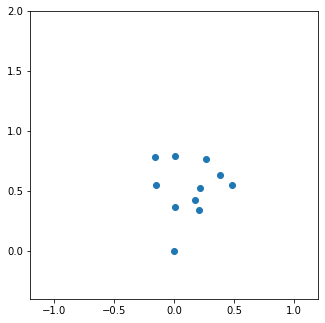

In [48]:
input_angle = [90,0,0,-180,0,0]
# input_deg = deg2rad(np.asarray(input_angle))
input_deg  = np.asarray([ 1.55897324,  0.72932609, -2.22291071, -1.89583754, -0.84427175,
        0.58565826])  # use this when use deg input
tst = pd.DataFrame([input_deg])
# tst.transpose(a)
columnname = list(tmp_result_df.columns)
tst.columns=columnname
drawskeleton(tst)

#### column

In [38]:
weight = np.load('w_synergy.npy')

In [47]:
mean+np.dot(np.array([1,1,0,0,0,0]),weight)

array([ 1.55897324,  0.72932609, -2.22291071, -1.89583754, -0.84427175,
        0.58565826])

In [45]:
mean = np.load('mean.npy')

array([ 1.32044059,  0.80127069, -0.98230249, -2.50097405, -0.66478617,
        0.5653576 ])